In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
House = pd.read_csv('karteek//rsrt_train.csv')

## finding missing values percentage

In [4]:
House.isnull().sum()/len(House) # no missing values found

nomination_date    0.0
cost               0.0
join_date          0.0
dob                0.0
parch              0.0
digital_address    0.0
proportion         0.0
name               0.0
family_max_age     0.0
country            0.0
income             0.0
house_country      0.0
previous_income    0.0
relation           0.0
city               0.0
target             0.0
index              0.0
dtype: float64

In [5]:
House.dtypes # data types of House

nomination_date     object
cost                 int64
join_date           object
dob                 object
parch              float64
digital_address      int64
proportion         float64
name                object
family_max_age     float64
country             object
income             float64
house_country       object
previous_income    float64
relation            object
city                object
target               int64
index               object
dtype: object

## converting nomination_date,join_date,dob to date format

In [6]:
House.nomination_date = pd.to_datetime(House.nomination_date)
House.join_date = pd.to_datetime(House.join_date)
House.dob = pd.to_datetime(House.dob)

## Age of person at nomination time and join time

In [7]:
House['nomination_date'] =House.nomination_date.apply(lambda x: x.year)
House['join_date'] =House.join_date.apply(lambda x: x.year)
House.dob = House.dob.apply(lambda x: x.year)

In [8]:
House['age_nomination'] = House['nomination_date'] - House['dob']
House['age_join'] = House['join_date'] - House['dob']

## removing the following columns

- **Column: Reason**
- nomination_date , dob , join_date - created age diff
- index - all unique

In [9]:
House_drop = ["nomination_date","join_date","dob","index"]
House.drop(House_drop, axis = 1,inplace = True)

## creating family size

In [10]:
House['Family_size'] = House['parch'] + 1

## locality of house as per country

In [11]:
House['House_location'] = np.where((House['country'] == House['house_country']),"Local" , "NRI")

In [12]:
House['digital_address'] = House['digital_address'].astype(str) # since its a pincode it has to be static

## converting currency to global(US Dollar)

In [13]:
columns = ["income" ,"cost", "previous_income"]
def currencyconversion(columns):
    conditions = [(House['country'] == "China"), House['country'] == "USA",House['country'] == "UK",House['country'] == "Pakistan" ,House['country'] == "India"]
   
    for eachcol in columns:
        choices = [House[eachcol] * 0.16 , House[eachcol] * 1 ,House[eachcol] * 1.39 ,House[eachcol] *  0.0090, House[eachcol] * 0.015] 
        House[eachcol] = np.select(conditions,choices,default = np.nan)

In [14]:
currencyconversion(columns)

## difference between income and finding promotion of candidate as per his income

In [15]:
House['income_diff'] = House['income'] - House['previous_income']
House['promotion_indicator']  = [1 if i > 0 else 0 for i in House.income_diff]

## Title,firstname , lastname extraction from name

In [16]:
House['temp1'] =  House['name'].str.split('.')
House['title'] = House['temp1'].str.get(0)
House['temp2'] = House['temp1'].str.get(1).str.split(' ')
House['firstname'] = House['temp2'].str.get(1)
House['lastname'] = House['temp2'].str.get(2)

In [63]:
del House['temp1']
del House['temp2']

<h1> EDA </h1>

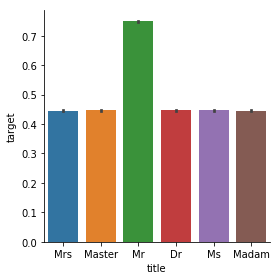

In [17]:
sns.factorplot(x = "title",y = "target",kind = "bar" , data=House) #people who are Mr have bought the houses more than others

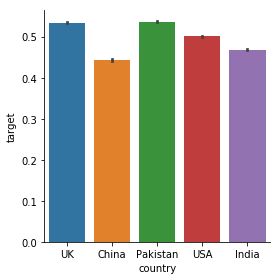

In [18]:
sns.factorplot(x = "country",y = "target",kind = "bar" , data=House) # ppl who live in china has bought less

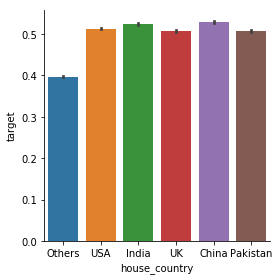

In [19]:
sns.factorplot(x = "house_country",y = "target",kind = "bar" , data=House)

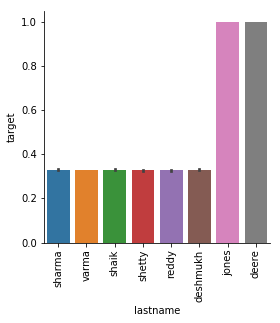

In [20]:
grid = sns.factorplot(x = "lastname",y = "target",kind = "bar" , data=House)
grid.set_xticklabels(rotation = 90) # ppl whos last name is jones and deere has bought the houses more

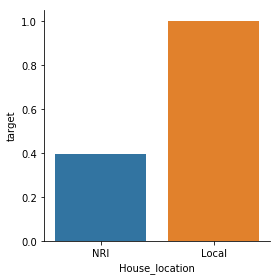

In [21]:
grid = sns.factorplot(x = "House_location",y = "target",kind = "bar" , data=House) 
# Local(if candidate country and house location country is same then they are sold more)

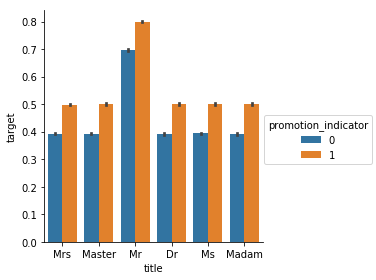

In [22]:
grid = sns.factorplot(x = "title",y = "target",hue = "promotion_indicator" , kind = "bar" , data=House)
# In all the categories promoted candidates bought more houses than ppl who are not promoted

## getting the columns of object type

In [23]:
df_str = House.select_dtypes(include=[np.object])
categorycolumns = df_str.columns.tolist()
categorycolumns

['digital_address',
 'name',
 'country',
 'house_country',
 'relation',
 'city',
 'House_location',
 'temp1',
 'title',
 'temp2',
 'firstname',
 'lastname']

## removing name as we got new columns from it and city as more unique columns found

In [24]:
del House['name']
del House['city']

In [25]:
House['target'].value_counts(normalize = True) # balanced state

0    0.503387
1    0.496613
Name: target, dtype: float64

## label encoding the category columns

In [26]:
from sklearn.preprocessing import LabelEncoder
cat_col = ['relation', 'House_location', 'title', 'firstname','lastname']

In [27]:
le = LabelEncoder()
for col in cat_col:
    House[col] = le.fit_transform(House[col])

In [28]:
del cat_col

## one hot encoding 
### as these are not ordinal and if done label encoding functionality may be missing
###### columns : digital_address,country,house_country

In [29]:
cat_one = ['digital_address','country','house_country']
for each in cat_one:
    dummies = pd.get_dummies(House[each],prefix = each,drop_first = False)
    House = pd.concat([House,dummies],axis = 1)

In [30]:
House.drop(cat_one,axis = 1,inplace=True) # dropping actual columns

## Modeling

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [65]:
feature_names = [x for x in House.columns if x not in ['target']]
target = House['target']

In [71]:
X = House[feature_names]
y = House['target']

In [72]:
X_train, X_valid, y_train, y_valid=  train_test_split(X,y,train_size = 0.7,stratify = y,random_state = 0)

C:\Users\AA\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Decission Tree

In [73]:
clf = DecisionTreeClassifier(random_state = 0)

In [74]:
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [77]:
f1_score(y_valid,clf.predict(X_valid))

0.9999304808091074

## cross validation with f score

In [78]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y_train)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [79]:
f1 = cross_val_score(clf, X_train, y_train, cv=3, scoring='f1')

In [80]:
f1

array([0.99991986, 0.99995993, 0.99992911])

In [81]:
from sklearn.metrics import confusion_matrix

In [82]:
confusion_matrix(y_valid,clf.predict(X_valid))

array([[211411,     12],
       [    17, 208561]], dtype=int64)

## Random Forest

In [83]:
rclf = RandomForestClassifier(random_state = 0)

In [84]:
rclf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [86]:
f1_score(y_valid,rclf.predict(X_valid))

0.998630770964671

## lets see grid search now instead of only kfold

In [95]:
from sklearn.model_selection import GridSearchCV
parameters = [{'max_depth' :[5,10,15,20] , 'max_features':[4,5,6]}]
grid_search = GridSearchCV(rclf,param_grid = parameters,scoring = 'f1',cv = 3,n_jobs = -1)

In [96]:
grid_search = grid_search.fit(X_train,y_train)

In [97]:
grid_search.best_score_

0.9990603594185444

In [98]:
grid_search.best_params_ # these are best params and you can put these in your classifier and run model

{'max_depth': 20, 'max_features': 6}

## xgboost

In [92]:
from xgboost import XGBClassifier

In [99]:
xgb = XGBClassifier(random_state = 0, n_estimators=100)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [100]:
f1_score(y_valid,xgb.predict(X_valid))

C:\Users\AA\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9991446212972525

## can perform Kfold and gridsearch same as above